<a href="https://colab.research.google.com/github/TaiNgoDuc/QuickDrawAI/blob/main/Sketcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get the Class names 

This file contains a subset of the quick draw classes. I choose around 100 classes from the dataset. 

In [ ]:
!wget 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy'
!wget 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy'
!wget 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/airplane.npy'
!wget 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sword.npy'
!wget 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/car.npy'

--2022-12-06 01:24:44--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 173.194.69.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104884384 (100M) [application/octet-stream]
Saving to: ‘sun.npy’

sun.npy             100%[===================>] 100.03M  34.3MB/s    in 2.9s    

2022-12-06 01:24:47 (34.3 MB/s) - ‘sun.npy’ saved [104884384/104884384]

--2022-12-06 01:24:47--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 173.194.69.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 176997488 (169M) [application/octet-str

Read the classes names 

In [ ]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [ ]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Download the Dataset 

Loop over the classes and download the currospondent data

In [ ]:
!mkdir data1

In [ ]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  root = 'data1'
  classes = ['sun', 'eyeglasses', 'airplane', 'sword', 'car']
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data1/'+c+'.npy')

In [ ]:
download() 

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/airplane.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sword.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/car.npy


# Imports 

In [ ]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

# Load the Data 

Each class contains different number samples of arrays stored as .npy format. Since we have some memory limitations we only load 5000 images per class.  

In [ ]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data1 = np.load(file)
        data1 = data1[0: max_items_per_class, :]
        labels = np.full(data1.shape[0], idx)

        x = np.concatenate((x, data1), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data1 = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [ ]:
x_train, y_train, x_test, y_test, class_names = load_data('data1')
num_classes = len(class_names)
image_size = 28

In [ ]:
print(len(x_train))

16000


Show some random data 

car


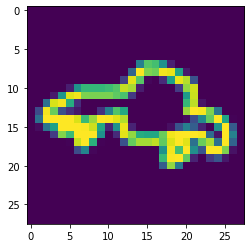

In [ ]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

# Preprocess the Data 

In [ ]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The Model 

In [ ]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(5, activation='softmax')) 
# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 3, 3, 64)        

# Training 

In [ ]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5 )

Epoch 1/5
57/57 - 13s - loss: 0.7915 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4166 - val_top_k_categorical_accuracy: 1.0000 - 13s/epoch - 233ms/step
Epoch 2/5
57/57 - 0s - loss: 0.3459 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3505 - val_top_k_categorical_accuracy: 1.0000 - 389ms/epoch - 7ms/step
Epoch 3/5
57/57 - 0s - loss: 0.2864 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2648 - val_top_k_categorical_accuracy: 1.0000 - 387ms/epoch - 7ms/step
Epoch 4/5
57/57 - 0s - loss: 0.2170 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2113 - val_top_k_categorical_accuracy: 1.0000 - 426ms/epoch - 7ms/step
Epoch 5/5
57/57 - 0s - loss: 0.1913 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2037 - val_top_k_categorical_accuracy: 1.0000 - 331ms/epoch - 6ms/step


# Testing 

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 100.00%


# Inference 

1/1 [==============================] - 0s 139ms/step
['eyeglasses', 'car', 'sun', 'airplane', 'sword']


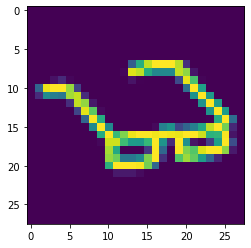

In [ ]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

# Store the classes 

In [ ]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [ ]:
!pip install tensorflowjs 

    100% |████████████████████████████████| 327kB 6.4MB/s 
    100% |████████████████████████████████| 12.2MB 3.5MB/s 
  Found existing installation: numpy 1.14.3
    Uninstalling numpy-1.14.3:
      Successfully uninstalled numpy-1.14.3
  Found existing installation: Keras 2.1.6
    Uninstalling Keras-2.1.6:
      Successfully uninstalled Keras-2.1.6


# Save and Convert 

In [ ]:
model.save('keras.h5')

In [ ]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

/bin/bash: tensorflowjs_converter: command not found


# Zip and Download 

In [ ]:
!cp class_names.txt model/class_names.txt

In [ ]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/group5-shard1of1 (deflated 7%)
  adding: model/model.json (deflated 82%)
  adding: model/group2-shard1of1 (deflated 7%)
  adding: model/group3-shard1of1 (deflated 7%)
  adding: model/class_names.txt (deflated 41%)
  adding: model/group1-shard1of1 (stored 0%)
  adding: model/group4-shard1of1 (deflated 7%)


In [ ]:
from google.colab import files
files.download('model.zip')